In [1]:
%precision 3

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from sklearn import preprocessing, decomposition
from IPython import display
from matplotlib import pyplot as plt
from matplotlib import ticker, collections, colors
plt.style.use("minimal")

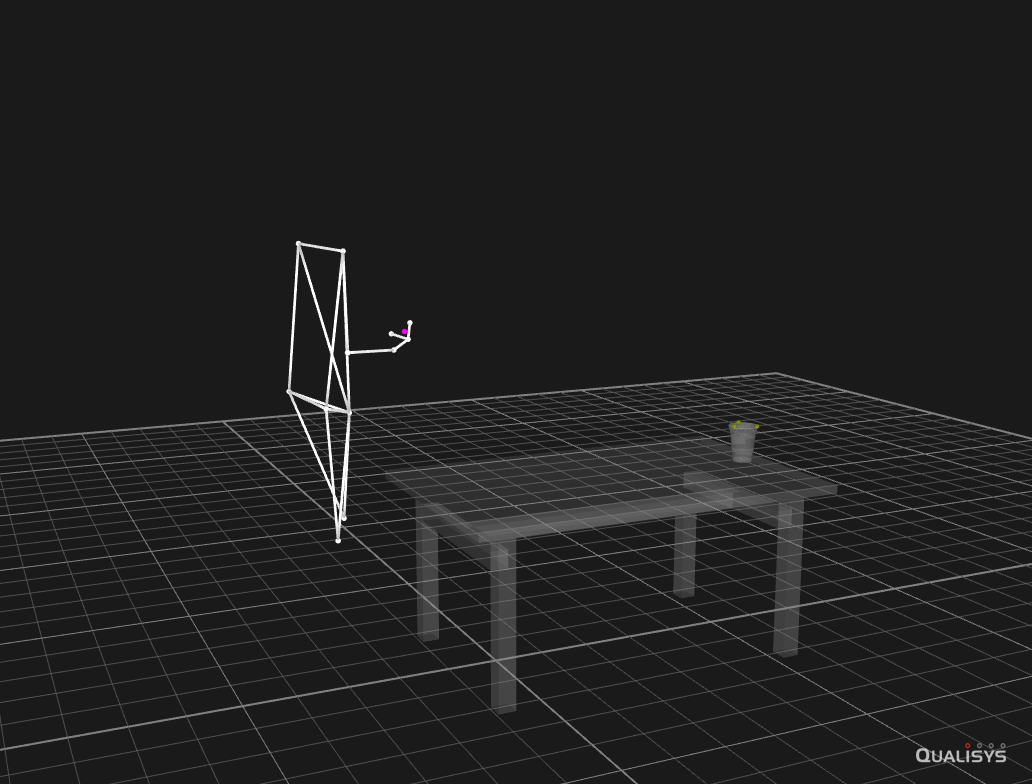

In [2]:
display.Image("../Export/full.gif")

In [3]:
SPATIAL_SCALE = 1000 # spatial measurements were recorded in millimeters
SAMPLE_RATE   =  300 # Hz (samples/second)
DATA_PATH     = "../data"

In [41]:
class Session:
    def __init__(self, session_id):
        self.id = session_id

        datafile_path = f"{DATA_PATH}/Demo{session_id}.tsv"

        metadata_header_lines = 9

        self.events = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = None, 
            names = ("Type", "EventType", "Frame", "Time"), 
            skiprows=metadata_header_lines, 
            on_bad_lines = "skip"
        ).drop(columns = ["Type"])

        marker_names = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = None, 
            skiprows=metadata_header_lines + len(self.events), 
            nrows = 1
        ).loc[0, 1:].values

        self.available_markers = list(sorted(marker_names))

        dataset = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = metadata_header_lines + len(self.events) + 2, 
            usecols = lambda name: "Unnamed" not in name
        )

        dataset = dataset.set_index(["Frame", "Time"])
        dataset.columns = dataset.columns.str.split(" ", expand = True)
        dataset = dataset.stack(0, dropna = False)
        dataset.index = dataset.index.rename(["Frame", "Time", "Marker"])
        dataset = dataset.reset_index()

        dataset["TrialTag"] = dataset["Frame"].isin(self.events[self.events["EventType"] == "Trial"]["Frame"])
        dataset["Trial"] = (dataset["TrialTag"].astype(int).diff() > 0).cumsum()
        dataset = dataset[dataset["Trial"] > 0]

        dataset["OutcomeTag"] = dataset["Frame"].isin(self.events[self.events["EventType"] == "Hit"]["Frame"])

        trials = []
        for trial, subset in dataset.groupby("Trial"):
            marker_collection = []
            subset["Frame"] -= subset["Frame"].min()
            subset["Time"] -= subset["Time"].min()
            for marker in self.available_markers:
                pos_data = subset[subset["Marker"] == marker][["Frame", "Time"] + list("XYZ")].set_index(["Frame", "Time"])
                pos_data = pos_data.interpolate(limit_direction = "both")
                pos_data = (pos_data / SPATIAL_SCALE) * 100 # rescale from mm/s to cm
                marker_collection.append(pos_data.reset_index())
            trial_data = pd.Series(marker_collection, name = "Marker", index = self.available_markers)
            trial_data.success = subset["OutcomeTag"].any()
            trials.append(trial_data)

        self.data = pd.Series(data = trials, index = np.arange(1, len(trials) + 1), name = "Trial")

        self.enhance()

    def calculate_speed(self, subset):
        delta_pos = (subset[["X", "Y", "Z"]].shift(1).values - subset[["X", "Y", "Z"]].values) * SAMPLE_RATE
        speed = np.sqrt(np.sum(delta_pos ** 2, axis = 1))
        speed = pd.Series(speed).rolling(int(SAMPLE_RATE / 10)).mean() # smoothen with rolling average
        speed /= 100 # rescale from cm/s to m/s
        return speed

    def calculate_acceleration(self, subset):
        return (subset["Speed"].diff() / SAMPLE_RATE).rolling(int(SAMPLE_RATE / 10)).mean() # smoothen with rolling average

    def sync_and_trim(self, subset, reference_timepoint, pre = None, post = None):
        if pre and post:
            subset = subset[(subset["Time"] > reference_timepoint - pre) & (subset["Time"] < reference_timepoint + post)].copy()
        subset["Time"] -= subset["Time"].min()
        subset.index -= subset.index.min()
        return subset

    def recenter_to_cup(self, subset, cup_centroid):
        subset[["X", "Y", "Z"]] = subset[["X", "Y", "Z"]].subtract(cup_centroid)
        return subset

    def enhance(self):
        for trial in self.data.index:
            cup_centroid = pd.DataFrame([self.data[trial][cup_marker][["X", "Y", "Z"]].median() for cup_marker in ["CupLeft", "CupRight", "CupFront"]]).mean()

            # adding derived measures
            for marker in self.data[trial].index:
                self.recenter_to_cup(self.data[trial][marker], cup_centroid)
                self.data[trial][marker]["Speed"] = self.calculate_speed(self.data[trial][marker])
                self.data[trial][marker]["Acceleration"] = self.calculate_acceleration(self.data[trial][marker])

            self.data.pre_dispatch_temporal_window = 0.25
            # trimming to throw by using max ball speed (terminal velocity)
            reference_timepoint = self.data[trial]["Ball"].iloc[self.data[trial]["Ball"]["Speed"].replace(np.nan, 0).idxmax()]["Time"]
            for marker in self.data[trial].index:
                self.data[trial][marker] = self.sync_and_trim(self.data[trial][marker], reference_timepoint, pre = 1, post = self.data.pre_dispatch_temporal_window)

            # trimming and "centering" around throw movement instead of terminal velocity
            reference_timepoint = self.data[trial]["Ball"].iloc[self.data[trial]["Ball"]["Acceleration"].replace(np.nan, 0).idxmax()]["Time"]
            for marker in self.data[trial].index:
                self.data[trial][marker] = self.sync_and_trim(self.data[trial][marker], reference_timepoint, pre = self.data.pre_dispatch_temporal_window, post = 1)

    def __repr__(self):
        return f"[Session {self.id}]" + "\n" + f"Trial{'s' if len(self.data) > 1 else ''} {self.data.index[0]}{'-' + str(self.data.index[-1]) if len(self.data.index) > 1 else ''}" + "\n" + f"{len(self.available_markers)} markers ({', '.join(self.available_markers)})"

session = Session(session_id = 6)
print(session)

data = session.data

[Session 6]
Trials 1-5
16 markers (Ball, CupFront, CupLeft, CupRight, Elbow, FingerIndex, FingerThumb, Groin, HandDorsum, HipLeft, HipRight, KneeLeft, KneeRight, ShoulderLeft, ShoulderRight, Wrist)


In [38]:
def annotate_metadata(marker, axis = None):
    plt.figtext(0.9, 0.9, f"{marker}" + f"{' ' + axis if axis else ''}", ha = "center")
    # plt.figtext(1, 0.04, f"{len(data)} trials", ha = "center", alpha = 0.5)

def mark_dispatch():
    plt.axvline(data.pre_dispatch_temporal_window, color = "black", linestyle = "--", linewidth = 1, alpha = 0.05, zorder = -1)

def decorate_xaxis_ticks():
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.gca().xaxis.set_major_formatter(lambda val, idx: int(val * 1000))
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.05))

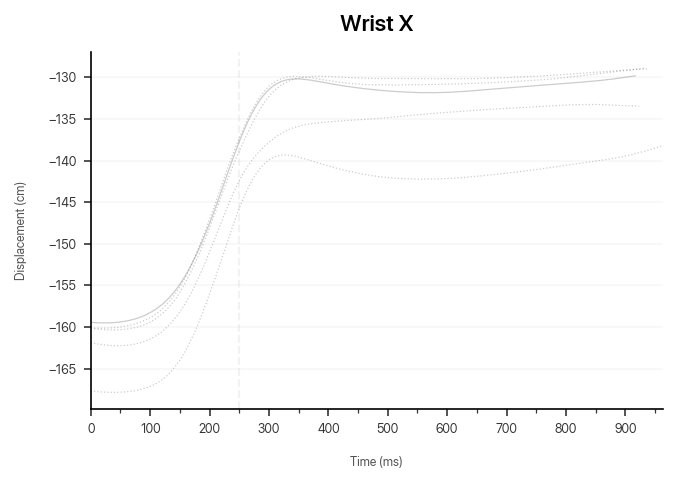

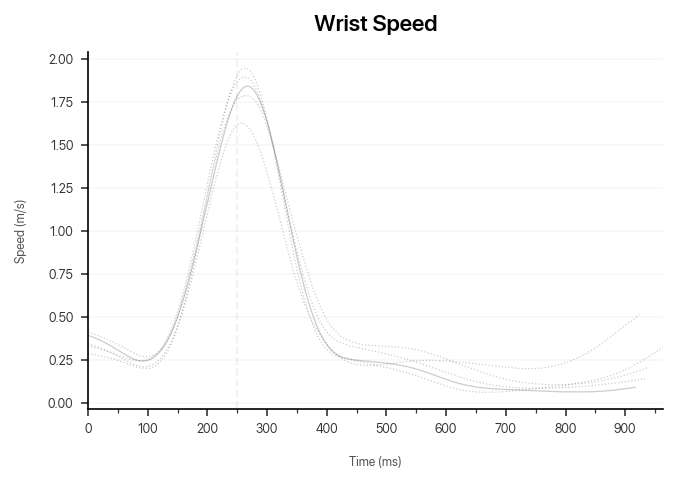

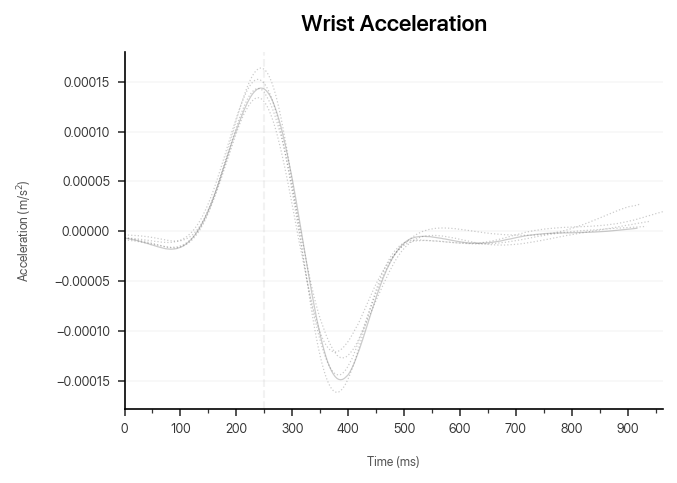

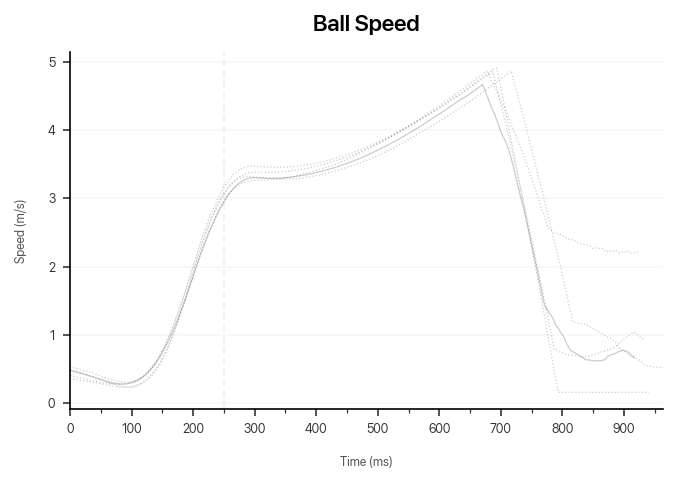

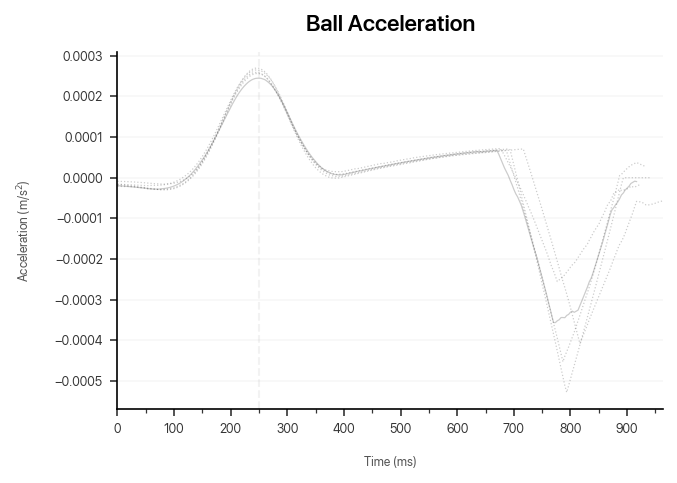

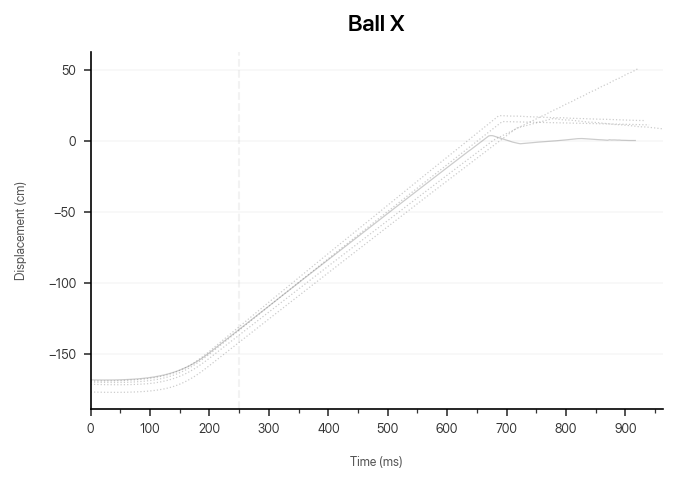

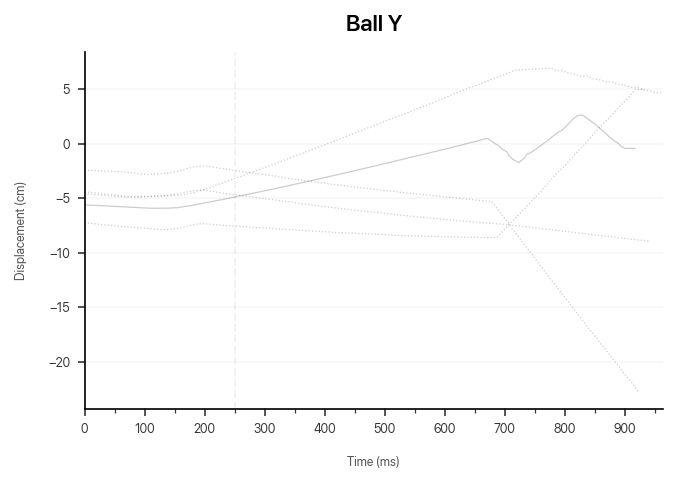

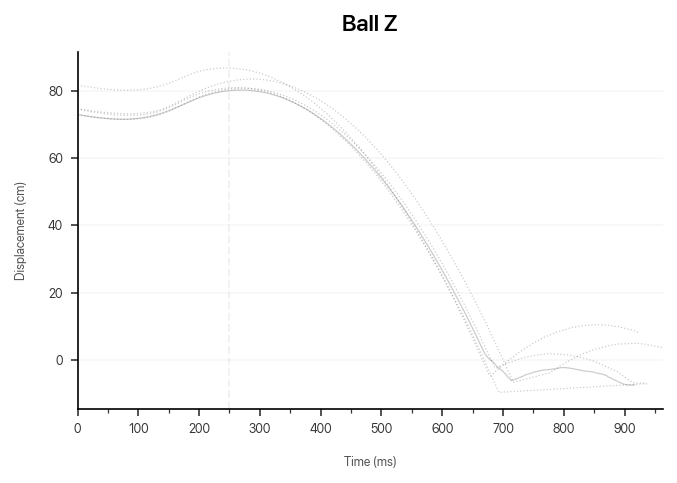

In [46]:
def plot_trajectory(marker, dimension):
    plt.figure()
    mark_dispatch()
    for trial, subset in data.items():
        plt.plot(
            subset[marker]["Time"],
            subset[marker][dimension], 
            color = "black",
            linewidth = 0.6, 
            linestyle = "-" if subset.success else ":",
            alpha = 0.2
        )

    plt.title(f"{marker} {dimension}")
    plt.xlabel("Time (ms)")
    if dimension == "Speed":
        plt.ylabel(f"{dimension} (m/s)")
    elif dimension == "Acceleration":
        plt.ylabel(f"{dimension} (m/s$^2$)")
    else:
        plt.ylabel("Displacement (cm)")

    decorate_xaxis_ticks()
    plt.margins(x = 0, y = 0.05)
    plt.tight_layout()

plot_trajectory(marker = "Wrist", dimension = "X")
plot_trajectory(marker = "Wrist", dimension = "Speed")
plot_trajectory(marker = "Wrist", dimension = "Acceleration")
plot_trajectory(marker = "Ball", dimension = "Speed")
plot_trajectory(marker = "Ball", dimension = "Acceleration")
plot_trajectory(marker = "Ball", dimension = "X")
plot_trajectory(marker = "Ball", dimension = "Y")
plot_trajectory(marker = "Ball", dimension = "Z")

In [45]:
def summary():
    result = []
    for trial, subset in data.items():

        knee_height = pd.concat([subset["KneeLeft"]["Z"], subset["KneeRight"]["Z"]], axis = 1).mean(axis = 1)

        after_passing_cup = subset["Ball"]["X"] > 0

        result.append({
            "Trial": trial, 
            # "Outcome": "✔" if subset.success else "✗",
            "Outcome": "Hit" if subset.success else "Miss",
            "Ball Max Speed (m/s)": subset["Ball"]["Speed"].max(), 
            "Ball Max Altitude (cm)": subset["Ball"]["Z"].max(),
            "Ball Altitude at Cup Projection (cm)": subset["Ball"][after_passing_cup].iloc[0]["Z"] if after_passing_cup.any() else np.nan,
            "Wrist Max Speed (m/s)": subset["Wrist"]["Speed"].max(),
            "Knee Displacement (cm)": knee_height.max() - knee_height.min(),
            "Distance to Cup at Dispatch (cm)": -subset["Ball"].iloc[int(data.pre_dispatch_temporal_window * SAMPLE_RATE)]["X"],
            "Deviation from Centerline at Dispatch (cm)": subset["Ball"].iloc[int(data.pre_dispatch_temporal_window * SAMPLE_RATE)]["Y"],
            "Elbow Altitude at Dispatch (cm)": subset["Elbow"]["Z"].loc[subset["Ball"]["Speed"].idxmax()],
        })

    return pd.DataFrame(result).set_index("Trial").round(2)

summary()

,Outcome,Ball Max Speed (m/s),Ball Max Altitude (cm),Ball Altitude at Cup Projection (cm),Wrist Max Speed (m/s),Knee Displacement (cm),Distance to Cup at Dispatch (cm),Deviation from Centerline at Dispatch (cm),Elbow Altitude at Dispatch (cm)
Trial,,,,,,,,,
1,Miss,4.86,86.67,-4.26,1.63,4.00,136.32,-2.47,50.62
2,Miss,4.86,83.41,4.09,1.95,7.29,141.42,-3.21,46.37
3,Miss,4.86,80.69,16.37,1.89,7.46,130.47,-7.55,46.14
4,Miss,4.91,80.87,6.18,1.79,7.35,132.88,-4.69,48.08
5,Hit,4.66,80.15,5.73,1.84,7.33,132.33,-4.91,45.41


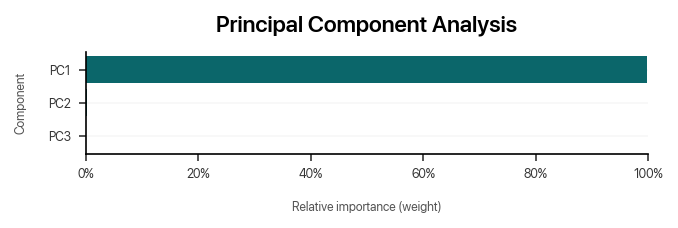

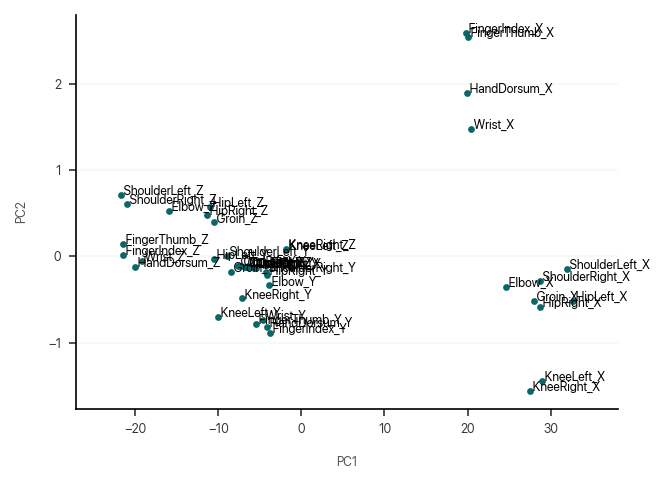

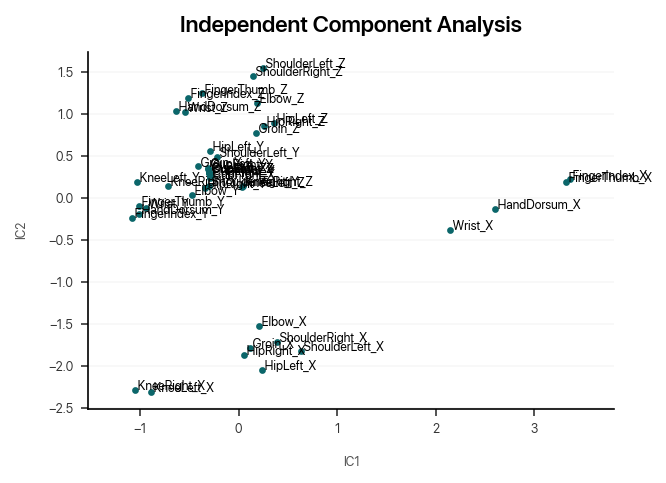

In [47]:
excluded_markers = ["Ball"]
all_positional_data = pd.concat([data[1][marker][["X", "Y", "Z"]].add_prefix(marker + "_") for marker in session.available_markers if not marker in excluded_markers], axis=1).dropna(axis = 1)
scaled_data = preprocessing.scale(all_positional_data.T)

def principal_component_analysis():
    n_components = 3
    pca = decomposition.PCA(n_components)
    pca.fit(scaled_data)
    component_labels = ["PC" + str(i) for i in range(1, n_components + 1)]

    plt.figure(figsize=(4.5, 1.5))
    plt.title("Principal Component Analysis")
    plt.barh(component_labels[::-1], pca.explained_variance_ratio_[::-1])
    plt.xlim((0, 1))
    plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.xlabel("Relative importance (weight)")
    plt.ylabel("Component")
    plt.tight_layout()

    plt.figure()
    pca_data = pd.DataFrame(pca.transform(scaled_data), index = all_positional_data.columns, columns = component_labels)
    plt.scatter(pca_data["PC1"], pca_data["PC2"], s = 5)
    for marker, components in pca_data.iterrows():
        plt.annotate(" " + marker, (components["PC1"], components["PC2"]), fontsize = 6)
    plt.margins(x = 0.1)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()

def independent_component_analysis():
    n_components = 2
    ica = decomposition.FastICA(n_components)
    ica.fit(scaled_data)
    component_labels = ["IC" + str(i) for i in range(1, n_components + 1)]

    plt.figure()
    plt.title("Independent Component Analysis")
    ica_data = pd.DataFrame(ica.transform(scaled_data), index = all_positional_data.columns, columns = component_labels)
    plt.scatter(ica_data["IC1"], ica_data["IC2"], s = 5)
    for marker, components in ica_data.iterrows():
        plt.annotate(" " + marker, (components["IC1"], components["IC2"]), fontsize = 6)
    plt.margins(x = 0.1)
    plt.xlabel("IC1")
    plt.ylabel("IC2")
    plt.tight_layout()

principal_component_analysis()
independent_component_analysis()